In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

wine = datasets.load_wine()
X, y = wine.data, wine.target

In [4]:
class LDA:
    
    ## Fitting the model 
    def fit(self, X, y):
        
        ## Record info
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        
        ## Get prior probabilities 
        self.unique_y, unique_y_counts = np.unique(self.y, return_counts = True) # returns unique y and counts
        self.pi_ks = unique_y_counts/self.N
        
        ## Get mu for each class and overall Sigma
        self.mu_ks = [] #means
        self.Sigma = np.zeros((self.D, self.D))        
        for i, k in enumerate(self.unique_y):
            
            X_k = self.X[self.y == k]
            mu_k = X_k.mean(0).reshape(self.D, 1)
            self.mu_ks.append(mu_k)

            for x_n in X_k:
                x_n = x_n.reshape(-1,1)
                x_n_minus_mu_k = (x_n - mu_k)
                self.Sigma += np.dot(x_n_minus_mu_k, x_n_minus_mu_k.T)
            
        self.Sigma /= self.N
        
        
    ## Making classifications

    def _mvn_density(self, x_n, mu_k, Sigma):
        x_n_minus_mu_k = (x_n - mu_k)
        density = np.exp(-(1/2)*x_n_minus_mu_k.T @ np.linalg.inv(Sigma) @ x_n_minus_mu_k)
        return density
            
    def classify(self, X_test):
        
        y_n = np.empty(len(X_test))
        for i, x_n in enumerate(X_test):
            
            x_n = x_n.reshape(-1, 1)
            p_ks = np.empty(len(self.unique_y))
        
            for j, k in enumerate(self.unique_y):
                p_x_given_y = self._mvn_density(x_n, self.mu_ks[j], self.Sigma) #TO FIND LARGE p_HAT
                p_y_given_x = self.pi_ks[j]*p_x_given_y
                p_ks[j] = p_y_given_x
            
            y_n[i] = self.unique_y[np.argmax(p_ks)]
        
        return y_n #output
            

In [5]:
lda = LDA()
lda.fit(X, y)
yhat = lda.classify(X)
np.mean(yhat == y)

1.0

In [6]:
def graph_boundaries(X, model, model_title, n0 = 100, n1 = 100, figsize = (7, 5), label_every = 4):
        
        # Generate X for plotting 
        d0_range = np.linspace(X[:,0].min(), X[:,0].max(), n0)
        d1_range = np.linspace(X[:,1].min(), X[:,1].max(), n1)
        X_plot = np.array(np.meshgrid(d0_range, d1_range)).T.reshape(-1, 2)
        
        # Get class predictions
        y_plot = model.classify(X_plot).astype(int)
        
        # Plot 
        fig, ax = plt.subplots(figsize = figsize)
        sns.heatmap(y_plot.reshape(n0, n1).T,
                   cmap = sns.color_palette('Pastel1', 3),
                   cbar_kws = {'ticks':sorted(np.unique(y_plot))})
        xticks, yticks = ax.get_xticks(), ax.get_yticks()
        ax.set(xticks = xticks[::label_every], xticklabels = d0_range.round(2)[::label_every],
               yticks = yticks[::label_every], yticklabels = d1_range.round(2)[::label_every])
        ax.set(xlabel = 'X1', ylabel = 'X2', title = model_title + ' Predictions by X1 and X2')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (25).

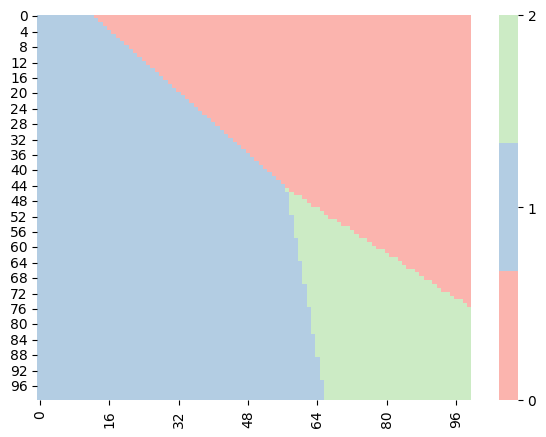

In [7]:
X_2d = X.copy()[:,2:4]
lda_2d = LDA()
lda_2d.fit(X_2d, y)
graph_boundaries(X_2d, lda_2d, 'LDA')

In [9]:
class QDA:
    
    ## Fitting the model
    
    def fit(self, X, y):
        
        ## Record info
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        
        
        ## Get prior probabilities 
        self.unique_y, unique_y_counts = np.unique(self.y, return_counts = True) # returns unique y and counts
        self.pi_ks = unique_y_counts/self.N
        
        
        ## Get mu and Sigma for each class
        self.mu_ks = []
        self.Sigma_ks = []
        for i, k in enumerate(self.unique_y):
            
            X_k = self.X[self.y == k]
            mu_k = X_k.mean(0).reshape(self.D, 1)
            self.mu_ks.append(mu_k)
            
            Sigma_k = np.zeros((self.D, self.D))
            for x_n in X_k:
                x_n = x_n.reshape(-1,1)
                x_n_minus_mu_k = (x_n - mu_k)
                Sigma_k += np.dot(x_n_minus_mu_k, x_n_minus_mu_k.T)
            self.Sigma_ks.append(Sigma_k/len(X_k))
     
    ## Making classifications 
    
    def _mvn_density(self, x_n, mu_k, Sigma_k):
        x_n_minus_mu_k = (x_n - mu_k)
        density = np.linalg.det(Sigma_k)**(-1/2) * np.exp(-(1/2)*x_n_minus_mu_k.T @ np.linalg.inv(Sigma_k) @ x_n_minus_mu_k)
        return density
    
    def classify(self, X_test):
        
        y_n = np.empty(len(X_test))
        for i, x_n in enumerate(X_test):
            
            x_n = x_n.reshape(-1, 1)
            p_ks = np.empty(len(self.unique_y))
        
            for j, k in enumerate(self.unique_y):

                p_x_given_y = self._mvn_density(x_n, self.mu_ks[j], self.Sigma_ks[j])
                p_y_given_x = self.pi_ks[j]*p_x_given_y
                p_ks[j] = p_y_given_x
            
            y_n[i] = self.unique_y[np.argmax(p_ks)]
        
        return y_n
            

In [10]:
qda = QDA()
qda.fit(X, y)
yhat = qda.classify(X)
np.mean(yhat == y)

0.9943820224719101

In [11]:
qda = QDA()
qda.fit(X, y)
yhat = qda.classify(X)
np.mean(yhat == y)

0.9943820224719101

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (25).

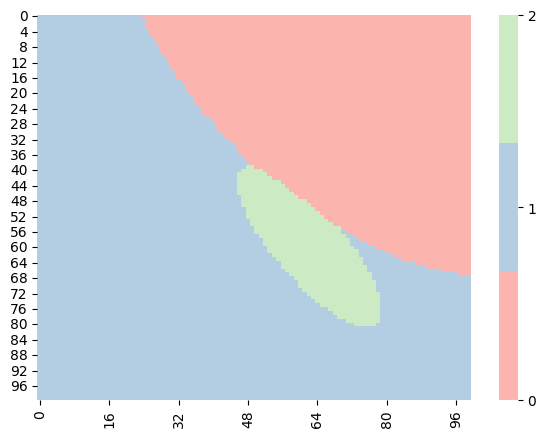

In [12]:
qda_2d = QDA()
qda_2d.fit(X_2d, y)
graph_boundaries(X_2d, qda_2d, 'QDA')

In [13]:
class NaiveBayes:
    
    ######## Fit Model ########

    def _estimate_class_parameters(self, X_k):
        
        class_parameters = []
        
        for d in range(self.D):
            X_kd = X_k[:,d] # only the dth column and the kth class
            
            if self.distributions[d] == 'normal':
                mu = np.mean(X_kd)
                sigma2 = np.var(X_kd)
                class_parameters.append([mu, sigma2])
            
            if self.distributions[d] == 'bernoulli':
                p = np.mean(X_kd)
                class_parameters.append(p)
                
            if self.distributions[d] == 'poisson':
                lam = np.mean(X_kd)
                class_parameters.append(p)
                
        return class_parameters
    
    def fit(self, X, y, distributions = None):
        
        ## Record info
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        if distributions is None:
            distributions = ['normal' for i in range(len(y))]
        self.distributions = distributions
        
        
        ## Get prior probabilities 
        self.unique_y, unique_y_counts = np.unique(self.y, return_counts = True) # returns unique y and counts
        self.pi_ks = unique_y_counts/self.N
        
        
        ## Estimate parameters
        self.parameters = []
        for i, k in enumerate(self.unique_y):
            X_k = self.X[self.y == k]
            self.parameters.append(self._estimate_class_parameters(X_k))
    
    
    ######## Make Classifications ########
            
    def _get_class_probability(self, x_n, j):
        
        class_parameters = self.parameters[j] # j is index of kth class
        class_probability = 1 
        
        for d in range(self.D):
            x_nd = x_n[d] # just the dth variable in observation x_n
            
            if self.distributions[d] == 'normal':
                mu, sigma2 = class_parameters[d]
                class_probability *= sigma2**(-1/2)*np.exp(-(x_nd - mu)**2/sigma2)
            
            if self.distributions[d] == 'bernoulli':
                p = class_parameters[d]
                class_probability *= (p**x_nd)*(1-p)**(1-x_nd)
                
            if self.distributions[d] == 'poisson':
                lam = class_parameters[d]
                class_probability *= np.exp(-lam)*lam**x_nd
                
        return class_probability 
            
    def classify(self, X_test):
        
        y_n = np.empty(len(X_test))
        for i, x_n in enumerate(X_test): # loop through test observations
            
            x_n = x_n.reshape(-1, 1)
            p_ks = np.empty(len(self.unique_y))
        
            for j, k in enumerate(self.unique_y): # loop through classes
                    
                p_x_given_y = self._get_class_probability(x_n, j)
                p_y_given_x = self.pi_ks[j]*p_x_given_y # bayes' rule

                p_ks[j] = p_y_given_x
            
            y_n[i] = self.unique_y[np.argmax(p_ks)]
        
        return y_n
            

In [14]:
nb = NaiveBayes()
nb.fit(X, y)
yhat = nb.classify(X)
np.mean(yhat == y)

0.9775280898876404

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (25).

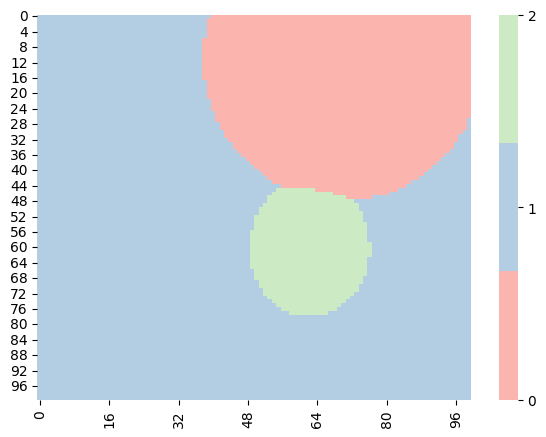

In [17]:
nb_2d = NaiveBayes()
nb_2d.fit(X_2d, y)
graph_boundaries(X_2d, nb_2d, 'Naive Bayes')

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

lda = LinearDiscriminantAnalysis()
lda.fit(X, y);

qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y);

nb = GaussianNB()
nb.fit(X, y);

In [22]:
def graph_boundaries(X, model, model_title, n0 = 1000, n1 = 1000, figsize = (7, 5), label_every = 4):
        
        # Generate X for plotting 
        d0_range = np.linspace(X[:,0].min(), X[:,0].max(), n0)
        d1_range = np.linspace(X[:,1].min(), X[:,1].max(), n1)
        X_plot = np.array(np.meshgrid(d0_range, d1_range)).T.reshape(-1, 2)
        
        # Get class predictions
        y_plot = model.predict(X_plot).astype(int)
        
        # Plot 
        fig, ax = plt.subplots(figsize = figsize)
        sns.heatmap(y_plot.reshape(n0, n1).T,
                   cmap = sns.color_palette('Pastel1', 3),
                   cbar_kws = {'ticks':sorted(np.unique(y_plot))})
        xticks, yticks = ax.get_xticks(), ax.get_yticks()
        ax.set(xticks = xticks[::label_every], xticklabels = d0_range.round(2)[::label_every],
               yticks = yticks[::label_every], yticklabels = d1_range.round(2)[::label_every])
        ax.set(xlabel = 'X1', ylabel = 'X2', title = model_title + ' Predictions by X1 and X2')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (250).

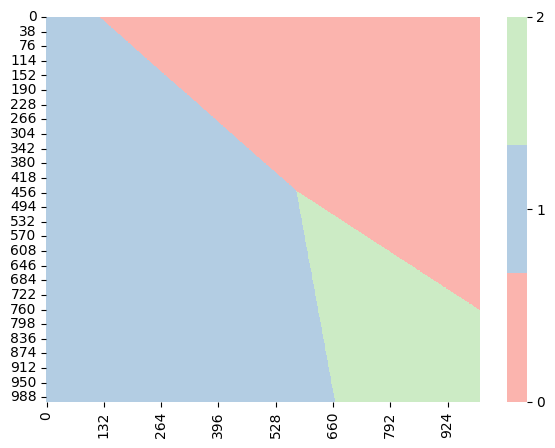

In [23]:
#Shows the graph of LDA
X_2d = X.copy()[:,2:4]
lda_2d = LinearDiscriminantAnalysis()
lda_2d.fit(X_2d, y);
graph_boundaries(X_2d, lda_2d, 'LDA')

#Show the graph of QDA
qda_2d = QuadraticDiscriminantAnalysis()
qda_2d.fit(X_2d, y);
graph_boundaries(X_2d, qda_2d, 'QDA')

#Show the graph of gaussianNB
X_2d = X.copy()[:,2:4]
lda_2d = LinearDiscriminantAnalysis()
lda_2d.fit(X_2d, y);
graph_boundaries(X_2d, lda_2d, 'LDA')